## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [1]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import urllib.request, urllib.parse, urllib.error
import requests
import json

In [2]:
API_key = '294f4c0e6d0861470f47e84017c8e2c1'

In [7]:
#The first API request is to obtain a list of movies by the released_date

def API_search(year,vote_count):
    #This request pulls the first page of the search request
    resp = requests.get('https://api.themoviedb.org/3/discover/movie?api_key=' + str(API_key) +'&language=en-US&vote_count.gte='+str(vote_count)+'&primary_release_year='+ str(year))
    data_p1 = dict(resp.json())

    #We can also use this request to see how many pages there are in the search, 
    #we will need to add all the pages of the search to the dataframe
    search_pages = data_p1['total_pages']
    data = pd.DataFrame.from_dict(data_p1['results'])
    url = 'https://api.themoviedb.org/3/discover/movie?api_key=' + str(API_key) +'&language=en-US&vote_count.gte='+str(vote_count)+'&primary_release_year='+ str(year)+'&page='
    for page in range(2,search_pages+1):
        resp = requests.get(url + str(page))
        temp = dict(resp.json())
        df_by_page = pd.DataFrame.from_dict(temp['results'])
        data = pd.concat([data,df_by_page], ignore_index=True)

    data = data.set_index('id')
    # Create a list of all the movies from the search above. Which is in decending popularity order.
    return data.index.values.tolist()


In [8]:
movies_index = []

vote_count = 1000
search_years = list(range(2010,2020))

for year in search_years:
    movies_index = movies_index + API_search(year,vote_count)
    
len(movies_index)

1189

Text(0.5, 1.0, 'Distribution of Vote Counts')

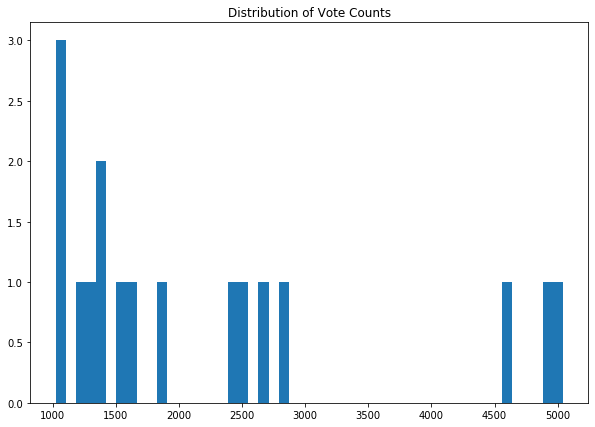

In [6]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# fig, ax = plt.subplots(figsize=(10, 7))
# ax.hist(data['vote_count'], bins=50)
# ax.set_title('Distribution of Vote Counts')
# ax.set_xlabel('Sale Price')
# ax.set_ylabel('Number of houses')
# ax.axvline(df['vote_count'].mean(), color='black');

In [35]:
#Here is an example of the API request data.  
#If we want to change our dataframes, to target more data, it would be easy to add in the function in an upcoming step
resp = requests.get('https://api.themoviedb.org/3/movie/' + str(movies_index[0]) + '?api_key=' + str(API_key))
# dict(resp.json())

In [9]:
#Defines a function to then arrange the data into a dictionary for a given movie.  

def API_request(movie):
    resp = requests.get('https://api.themoviedb.org/3/movie/' + str(movie) + '?api_key=' + str(API_key))
    if resp.status_code == requests.codes.ok:
        temp = dict(resp.json())
        movie = {}
        movie['imdb_id'] = temp['imdb_id']
        movie['release_date'] = pd.to_datetime(temp['release_date'])
        movie['genres'] = [genre['name'] for genre in temp['genres']]
        movie['title'] = temp['title']
        movie['budget'] = int(temp['budget'])
        movie['revenue'] = int(temp['revenue'])
        #movie['ROI'] =  (int(temp['revenue']) - int(temp['budget']))
        movie['runtime_mins'] = temp['runtime']
        movie['vote_average'] = temp['vote_average']        
        movie['vote_count'] = temp['vote_count']        
        return movie

In [37]:
#See an example of what the API_request provides per movie
print(API_request(movies_index[0]))

{'imdb_id': 'tt1375666', 'release_date': Timestamp('2010-07-15 00:00:00'), 'genres': ['Action', 'Science Fiction', 'Adventure'], 'title': 'Inception', 'budget': 160000000, 'revenue': 825532764, 'runtime_mins': 148, 'vote_average': 8.3, 'vote_count': 26442}


In [10]:
## Execution time varies on how large our subset is ##

#Define how many of the top most popular movies we would like to use in our dataset:
# subset_lenght = 500

#Shrinks the movies_index which is arranged from most popular to least popular, 
#and calls the first "subset_lenght" amount.
# imdb_ID_subset = movies_index[:subset_lenght]
imdb_ID_subset = movies_index

#Make requests to the API for the movie data
imbd_API_data = list(map(lambda x: API_request(x),imdb_ID_subset))

In [11]:
#Create a dataframe of the data obtained
df = pd.DataFrame.from_dict(imbd_API_data)


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1189 entries, 0 to 1188
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   imdb_id       1189 non-null   object        
 1   release_date  1189 non-null   datetime64[ns]
 2   genres        1189 non-null   object        
 3   title         1189 non-null   object        
 4   budget        1189 non-null   int64         
 5   revenue       1189 non-null   int64         
 6   runtime_mins  1189 non-null   int64         
 7   vote_average  1189 non-null   float64       
 8   vote_count    1189 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 83.7+ KB


In [13]:
#Split the genres column into individual rows and set the index to "imbd_id"
s = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
cleaned_df = df.drop('genres',axis=1).join(s).set_index('imdb_id')
cleaned_df.to_csv('2010-2019.csv')

cleaned_df

,release_date,title,budget,revenue,runtime_mins,vote_average,vote_count,genre
imdb_id,,,,,,,,
tt1375666,2010-07-15,Inception,160000000,825532764,148,8.3,26442,Action
tt1375666,2010-07-15,Inception,160000000,825532764,148,8.3,26442,Science Fiction
tt1375666,2010-07-15,Inception,160000000,825532764,148,8.3,26442,Adventure
tt0814255,2010-02-01,Percy Jackson & the Olympians: The Lightning T...,95000000,226497209,119,6.2,5237,Adventure
tt0814255,2010-02-01,Percy Jackson & the Olympians: The Lightning T...,95000000,226497209,119,6.2,5237,Fantasy
...,...,...,...,...,...,...,...,...
tt9252508,2019-09-13,Tall Girl,0,0,101,6.2,1031,Comedy
tt9252508,2019-09-13,Tall Girl,0,0,101,6.2,1031,Drama
tt9252508,2019-09-13,Tall Girl,0,0,101,6.2,1031,Romance


In [15]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56 entries, tt3794354 to tt0983946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   release_date  56 non-null     datetime64[ns]
 1   title         56 non-null     object        
 2   budget        56 non-null     int64         
 3   revenue       56 non-null     int64         
 4   runtime_mins  56 non-null     int64         
 5   vote_average  56 non-null     float64       
 6   vote_count    56 non-null     int64         
 7   genre         56 non-null     object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 3.9+ KB
